In [ ]:
!pip install tensorflow opencv-contrib-python youtube-dl moviepy pydot
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2514944/45929032 bytes (5.5%)5554176/45929032 bytes (12.1%)8888320/45929032 bytes (19.4%)12304384/45929032 bytes (26.8%)15654912/45929032 bytes (34.1%)18907136/45929032 bytes (41.2%)22216704/45929032 bytes (48.4%)25403392/45929032 bytes (55.3%)28803072/45929032 bytes (62.7%)32014336/45929032 bytes (69.7%)35266560/45929032 bytes (76.8%)38453248/45929032 bytes (83.7%)

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

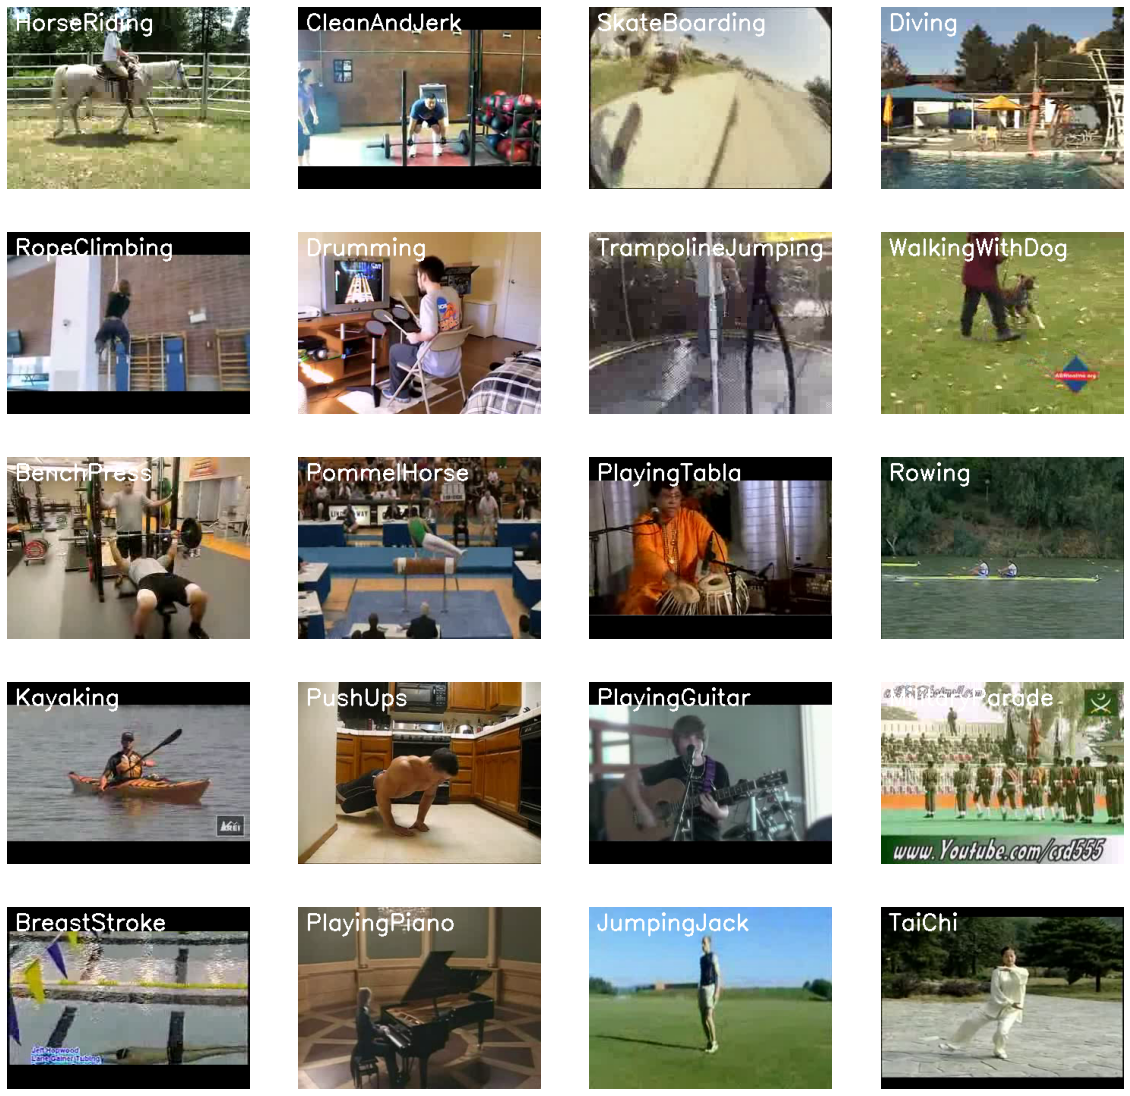

In [ ]:
plt.figure(figsize = (20, 20))
all_classes_names = os.listdir('/content/drive/MyDrive/Colab Notebooks/UCF50')
random_range = random.sample(range(len(all_classes_names)), 20)
for counter, random_index in enumerate(random_range, 1):
    selected_class_Name = all_classes_names[random_index]
    video_files_names_list = os.listdir(f'/content/drive/MyDrive/Colab Notebooks/UCF50/{selected_class_Name}')
    selected_video_file_name = random.choice(video_files_names_list)
    video_reader = cv2.VideoCapture(f'/content/drive/MyDrive/Colab Notebooks/UCF50/{selected_class_Name}/{selected_video_file_name}')
    _, bgr_frame = video_reader.read() 
    video_reader.release()
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [ ]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 20
DATASET_DIR = "/content/drive/MyDrive/Colab Notebooks/UCF50"
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

In [ ]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read() 
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    video_reader.release()
    return frames_list

In [ ]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):

        print(f'/content/drive/MyDrive/Colab Notebooks/UCF50/Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels, video_files_paths

In [ ]:
features, labels, video_files_paths = create_dataset()

/content/drive/MyDrive/Colab Notebooks/UCF50/Extracting Data of Class: WalkingWithDog
/content/drive/MyDrive/Colab Notebooks/UCF50/Extracting Data of Class: TaiChi
/content/drive/MyDrive/Colab Notebooks/UCF50/Extracting Data of Class: Swing
/content/drive/MyDrive/Colab Notebooks/UCF50/Extracting Data of Class: HorseRace


In [ ]:
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.20, shuffle = True,
                                                                            random_state = seed_constant)

In [ ]:
def create_convlstm_model():
 

    model = Sequential()

    # Define the Model Architecture.
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    

    model.summary()
    
    # Return the constructed convlstm model.
    return model

In [ ]:
convlstm_model = create_convlstm_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

In [ ]:
#plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

In [ ]:
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2)

Epoch 1/50
78/78 [==============================] - 175s 2s/step - loss: 0.1116 - accuracy: 0.9678 - val_loss: 0.7770 - val_accuracy: 0.7308
Epoch 2/50
78/78 [==============================] - 156s 2s/step - loss: 0.1187 - accuracy: 0.9550 - val_loss: 0.6570 - val_accuracy: 0.8077
Epoch 3/50
78/78 [==============================] - 158s 2s/step - loss: 0.0979 - accuracy: 0.9678 - val_loss: 1.0699 - val_accuracy: 0.6667
Epoch 4/50
78/78 [==============================] - 157s 2s/step - loss: 0.1141 - accuracy: 0.9550 - val_loss: 0.9353 - val_accuracy: 0.7949
Epoch 5/50
78/78 [==============================] - 157s 2s/step - loss: 0.1266 - accuracy: 0.9582 - val_loss: 0.6271 - val_accuracy: 0.7821
Epoch 6/50
78/78 [==============================] - 156s 2s/step - loss: 0.0674 - accuracy: 0.9807 - val_loss: 0.7255 - val_accuracy: 0.7949
Epoch 7/50
78/78 [==============================] - 157s 2s/step - loss: 0.0213 - accuracy: 0.9936 - val_loss: 0.8412 - val_accuracy: 0.7308
Epoch 8/50
78

In [ ]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

4/4 [==============================] - 17s 3s/step - loss: 0.9159 - accuracy: 0.7755


In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save('/content/drive/MyDrive/Colab Notebooks/UCF50/'+model_file_name)

In [ ]:
convlstm_model_training_history1 = convlstm_model.fit(x = features_train, y = labels_train, epochs = 2, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2)

Epoch 1/2
78/78 [==============================] - 161s 2s/step - loss: 2.8318e-04 - accuracy: 1.0000 - val_loss: 0.7952 - val_accuracy: 0.8077
Epoch 2/2
78/78 [==============================] - 169s 2s/step - loss: 3.0192e-04 - accuracy: 1.0000 - val_loss: 0.8415 - val_accuracy: 0.7949
